In [ ]:
#This code computes medians of errors and uses bootstrapping to calculate errors of medians

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('../machine-scientist/')
sys.path.append('../machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import bootstrap

In [2]:
#Read errors and take rmse
all_errors=pd.read_csv('../../data/'+ 'all_errors_nguyen_interpolation' + '.csv',index_col=0)
columns=["sigma", "function","rmse_nn_interp.", "rmse_nn_extrap.", "rmse_mdl_interp.", "rmse_mdl_extrap.","r"]
all_errors=all_errors[columns]
display(all_errors)

,sigma,function,rmse_nn_interp.,rmse_nn_extrap.,rmse_mdl_interp.,rmse_mdl_extrap.,r
0,0.00,1,0.105941,2.423783,1.968682e-16,8.514391e-16,0
1,0.00,1,0.127573,2.593338,2.084592e-16,7.405598e-16,1
2,0.00,1,0.132700,2.613626,2.380712e-16,1.114327e-15,2
3,0.02,1,0.100904,2.421923,6.553932e-03,2.940264e-01,0
4,0.02,1,0.145456,2.679691,2.444490e-03,1.886998e-02,1
...,...,...,...,...,...,...,...
160,0.18,10,0.031950,0.091976,4.176582e-02,5.997377e-02,1
161,0.18,10,0.028031,0.115821,3.752217e-02,5.873141e-02,2
162,0.20,10,0.069848,0.289061,4.542132e-02,1.374361e-01,0
163,0.20,10,0.032984,0.045248,1.029743e-01,7.009051e-02,1


In [3]:
#Melt dataframes and divide train and test
errors_inter=all_errors[["sigma", "function","rmse_nn_interp.", "rmse_mdl_interp.","r"]]
errors_inter=pd.melt(errors_inter,id_vars=["sigma","function","r"], var_name="error_interp",value_name= "value_interp")

errors_extra=all_errors[["sigma", "function","rmse_nn_extrap.", "rmse_mdl_extrap.","r"]]
errors_extra=pd.melt(errors_extra,id_vars=["sigma","function", "r"], var_name="error_extrap", value_name= "value_extrap")

display(errors_inter)

display(errors_extra)

,sigma,function,r,error_interp,value_interp
0,0.00,1,0,rmse_nn_interp.,0.105941
1,0.00,1,1,rmse_nn_interp.,0.127573
2,0.00,1,2,rmse_nn_interp.,0.132700
3,0.02,1,0,rmse_nn_interp.,0.100904
4,0.02,1,1,rmse_nn_interp.,0.145456
...,...,...,...,...,...
325,0.18,10,1,rmse_mdl_interp.,0.041766
326,0.18,10,2,rmse_mdl_interp.,0.037522
327,0.20,10,0,rmse_mdl_interp.,0.045421
328,0.20,10,1,rmse_mdl_interp.,0.102974


,sigma,function,r,error_extrap,value_extrap
0,0.00,1,0,rmse_nn_extrap.,2.423783
1,0.00,1,1,rmse_nn_extrap.,2.593338
2,0.00,1,2,rmse_nn_extrap.,2.613626
3,0.02,1,0,rmse_nn_extrap.,2.421923
4,0.02,1,1,rmse_nn_extrap.,2.679691
...,...,...,...,...,...
325,0.18,10,1,rmse_mdl_extrap.,0.059974
326,0.18,10,2,rmse_mdl_extrap.,0.058731
327,0.20,10,0,rmse_mdl_extrap.,0.137436
328,0.20,10,1,rmse_mdl_extrap.,0.070091


In [32]:
func_number=10   #1,5,7,8,10

errors_inter_plot=errors_inter[errors_inter['function']==func_number]
errors_extra_plot=errors_extra[errors_extra['function']==func_number]

titles={1: r'$y_1=3.39 x^3 + 2.12 x^2 +1.78x$',
        5: r'$y_5=\sin(x^2) \cos(x)$', 
        7: r'$y_7=\log(x+1.4) + \log(x^2 + 1.3)$',
        8: r'$y_8=\sqrt{1.23x}$',
        10:r'$y_{10}=\sin(1.5x) \cos(0.5y)$' }

In [33]:
#Figure configuration
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 8*cm; height=6*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=12;size_ticks=10;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
m_size=6

output_path='../../results/'

resamples=100000; bs_seed=1111 #number of resamples
ymin=1e-17;ymax=10

<Figure size 944.882x708.661 with 0 Axes>

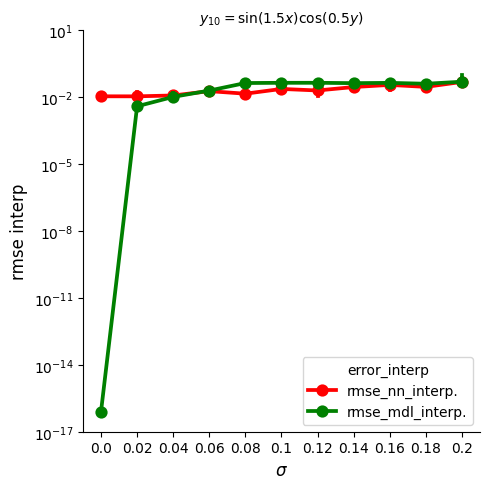

<Figure size 944.882x708.661 with 0 Axes>

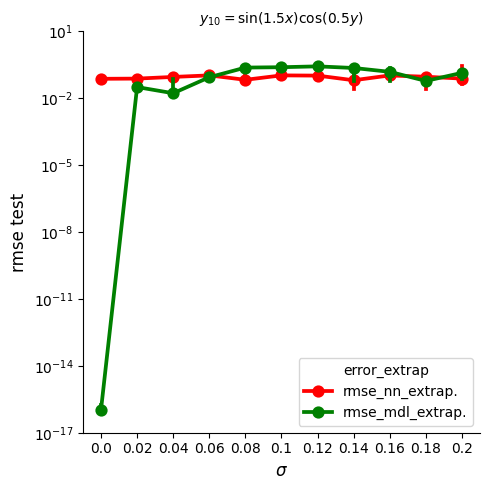

In [34]:
#Plot nguyen interpolation
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_inter_plot, x='sigma', y='value_interp', hue='error_interp', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)

plt.title(titles[func_number],fontsize=size_ticks)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse interp',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig='nguyen_' + str(func_number) + '_interpolation_medians_train'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#Plot nguyen extrapolation
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_extra_plot, x='sigma', y='value_extrap', hue='error_extrap', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)

plt.title(titles[func_number],fontsize=size_ticks)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse test',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig='nguyen_' + str(func_number) + '_extrapolations_medians_test'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

(1e-17, 10)

<Figure size 944.882x708.661 with 0 Axes>

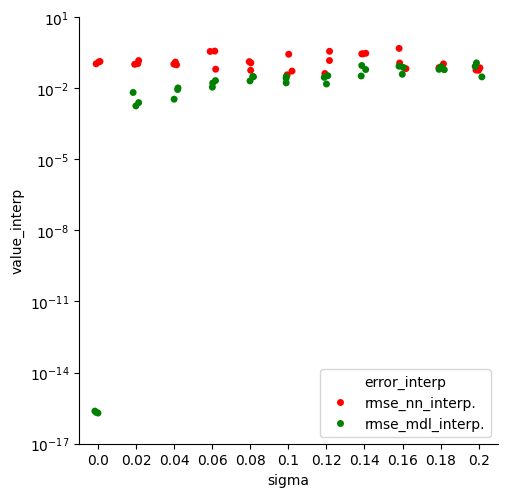

<Figure size 944.882x708.661 with 0 Axes>

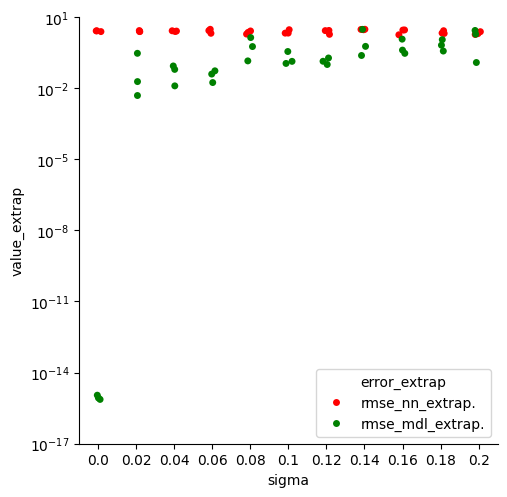

In [19]:
#Plot individual results
#Show individual results
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_inter_plot, x='sigma', y='value_interp', hue='error_interp',palette=['red', 'green'],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)

fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_extra_plot, x='sigma', y='value_extrap', hue='error_extrap',palette=['red', 'green'],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)